In [1]:
import random
import os
from urllib import request

# Resources

In order to run this notebook, you first need the following: 

## The _Don't Patronize Me!_ dataset

Files contained in the _Don't Patronize Me!_ data file, which you can access from [here](https://github.com/Perez-AlmendrosC/dontpatronizeme) (you need to fill a short form and it will be sent to you).

## The `dont_patronize_me.py` module

You can get this file by running the cell below.

In [2]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


## The official scorer

The script `evaluation.py` can also be obtained by running the cell below:

In [3]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/evaluation.py


At this point, your left pane on Google Colab should look like this:

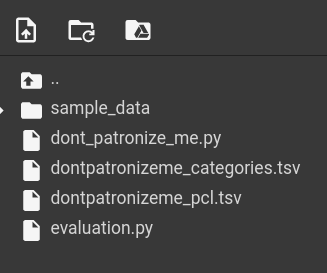

In [5]:
from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two areguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('data', 'dontpatronizeme_pcl.tsv')

# Load Subtask 1 data

Note that the original dataset contains fine-grained tags (0 to 4, both inclusive). The interface we provide collapses them into binary labels, which is the labeling we use for the task.

In [6]:
# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
dpm.train_task1_df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0


# Load Subtask 2 data

Similarly, you can use our data manager code to have a binary vector representing the labels of each paragraph in the multilabel classification subtask (PCL categories, Subtask 2).

In [ ]:
# Same for subtask 2
dpm.load_task2()
# which we can then access as a dataframe
dpm.train_task2_df.head()

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


FileNotFoundError: ignored

In [ ]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

# Generate predictions

In this example, our code will just generate a bunch of random predictions for both subtasks.

In [ ]:
# first, we need to create the res/ and ref/ folders, which the evaluator expects
!mkdir ref res

In [ ]:
dpm.load_test()

In [ ]:
# random predictions for task 1
preds_task1 = [[random.randint(0,1)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task1, os.path.join('res/', 'task1.txt'))

In [ ]:
# random predictions for task 2
preds_task2 = [[random.choice([0,1]) for k in range(7)] for k in range(0,len(dpm.test_set))]
labels2file(preds_task2, os.path.join('res/', 'task2.txt'))

# Evaluate predictions

After generating two prediction files (`task1.txt` and `task2.txt`), we can just call the scorer (`evaluation.py`), which will generate a `scores.txt` file.

## Get gold labels

We will use the gold labels of the training set and compare our random predictions to them.

In [ ]:
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
labels2file(dpm.train_task1_df.label.apply(lambda x:[x]).tolist(), os.path.join('ref/', 'task1.txt'))
# and for subtask 2
labels2file(dpm.train_task2_df.label.tolist(), os.path.join('ref/', 'task2.txt'))

## Call task scorer and print results

In [ ]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python3 evaluation.py . .

In [ ]:
# The scorer generated a results file called "scores.txt". 
# We can now see the performance of a random baseline on the training set.
!cat scores.txt

# Project Work (Kai and Mustafa)



## Preprocessing for standard ML model building for task 1

In [ ]:
# This cell is boilerplate copied from the HW3 word_embedding.ipynb
import gensim.downloader as api

def download_word2vec_embeddings():
    print("Beginning pre-trained word embedding download")
    wv = api.load("word2vec-google-news-300")
    print(f"\nLoading completed\nVocab size: {len(wv.vocab)}")
    return wv

word2vec = download_word2vec_embeddings()

In [ ]:
!pip install nltk
import nltk
from preprocess import clean_text
nltk.download('punkt')
dpm.train_task1_df["tokenized"] = dpm.train_task1_df["text"].apply(lambda x: nltk.word_tokenize(clean_text(x)))

In [ ]:
import numpy as np
# Generate paragraph embeddings for a given text by averaging (which is what I assume they did)
def paragraph_embedding(sentence: list) -> np.ndarray:
    words = [word for word in sentence if word in word2vec.vocab]
    return np.mean(word2vec[words], axis=0)

In [ ]:
from sklearn import model_selection
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(dpm.train_task1_df["tokenized"],dpm.train_task1_df["label"],test_size=0.2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
Encoder = LabelEncoder()
train_Y = Encoder.fit_transform(train_Y)
test_Y = Encoder.fit_transform(test_Y)

In [ ]:
# Turn the train_X into a 2d sample x feature vector using paragraph_embedding
train_X_para_embed = np.array([paragraph_embedding(text) for text in train_X])
test_X_para_embed = np.array([paragraph_embedding(text) for text in test_X])
train_X_para_embed.shape

## SVM-WV

In [ ]:
from sklearn.svm import SVC

#Model based on hyperperameters found here https://aclanthology.org/2020.coling-main.518.pdf
SVM = SVC(C=100, kernel="poly", gamma="scale")
SVM.fit(train_X_para_embed,train_Y)
predictions_SVM = SVM.predict(test_X_para_embed)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_SVM, test_Y))

## SVM-BoW

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_X_bow = vectorizer.fit_transform(dpm.train_task1_df['text'])
train_X_bow

In [ ]:
#Model based on hyperperameters found here https://aclanthology.org/2020.coling-main.518.pdf
SVM_bow = SVC(C=10, kernel="rbf", gamma="scale")
SVM_bow.fit(train_X_para_embed,train_Y)
predictions_SVM_bow = SVM_bow.predict(test_X_para_embed)

In [ ]:
classification_report(predictions_SVM_bow, test_Y)

## Fine-tuning BERT

### Setup and Data Prep

In [7]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 61 kB 459 kB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 895 kB 36.0 MB/s 
     |████████████████████████████████| 596 kB 37.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.empty_cache()
print(device)
print(torch.cuda.memory_summary())

cuda
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0

In [9]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded_input = tokenizer.__call__(dpm.train_task1_df['text'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128, return_attention_mask=True)


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [10]:
from torch.utils.data import TensorDataset, random_split

# use 80/20 split for training and validation as in the ML section

dataset = TensorDataset(encoded_input.input_ids, encoded_input.attention_mask, torch.tensor(dpm.train_task1_df.label.values))
bert_train_dataset, bert_val_dataset = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_dataloader = DataLoader(bert_train_dataset, sampler=RandomSampler(bert_train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(bert_val_dataset, sampler=SequentialSampler(bert_val_dataset), batch_size=batch_size)

### Model Preparation

In [12]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
if device == "cuda":
    model.cuda()

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Code is based on and uses snippets from: https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128 

In [13]:
from transformers import AdamW, BertConfig
optimizer = AdamW(model.parameters(), lr = 3e-5)

In [16]:
from transformers import get_linear_schedule_with_warmup

epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [17]:
import numpy as np
from tqdm import tqdm, trange

model.zero_grad()
epoch_iterator = trange(epochs, desc="Epoch")

seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed_all(seed)


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

### Training Loop

In [21]:
train_losses = []
for _ in epoch_iterator:
    data_iterator = tqdm(train_dataloader, desc="Iteration")
    model.train()
    train_loss = 0
    for batch in data_iterator:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0], 
                  'attention_mask': batch[1], 
                  'labels':         batch[2]}
        model.zero_grad()
        model.to(device)
        outputs = model(**inputs)
        loss = outputs[0]
        train_loss += loss.item()
        train_losses = np.append(train_losses, loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = train_loss / len(train_dataloader)

Iteration: 100%|██████████| 131/131 [02:40<00:00,  1.23s/it]


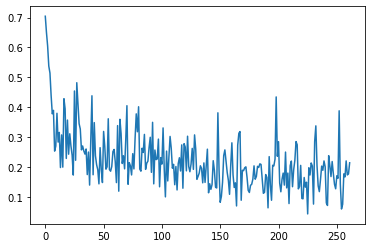

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

## Validation

In [28]:
from sklearn.metrics import classification_report
val_losses = []
preds = None
for val_steps, batch in enumerate(tqdm(val_dataloader, desc="Evaluating"), start=1):
    model.eval()
    batch = tuple(b.to(device) for b in batch)
    val_loss = 0
    with torch.no_grad():
        inputs = {'input_ids':      batch[0], 
                  'attention_mask': batch[1], 
                  'labels':         batch[2]}
        outputs = model(**inputs)
        loss, logits = outputs[:2]
        val_loss += loss.mean().item()
        val_losses = np.append(val_losses, val_loss)
    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
avg_val_loss = val_loss / val_steps
preds = np.argmax(preds, axis=1)
result = classification_report(out_label_ids, preds)
print(result)

Evaluating: 100%|██████████| 33/33 [00:15<00:00,  2.14it/s]

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1878
           1       0.63      0.37      0.46       216

    accuracy                           0.91      2094
   macro avg       0.78      0.67      0.71      2094
weighted avg       0.90      0.91      0.90      2094



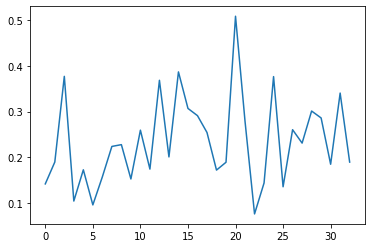

In [29]:

plt.plot(val_losses)